In [1]:
import numpy as np
try:  
    import cupy as xp  
    USE_GPU = True 
except ImportError:  
    import numpy as xp 
    print('No Cupy')
    USE_GPU = False 

import matplotlib.pyplot as plt
from tqdm import tqdm

# to mute the warnings of lal 
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import * 
from Triangle.GW import * 
from Triangle.TDI import * 

from gbgpu.gbgpu import GBGPU
from gbgpu.utils.constants import *
from gbgpu.utils.utility import *

# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

# np.random.seed(114514)

No Cupy


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/gbgpu/gbgpu.py:25: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/gbgpu/utils/utility.py:15: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")


## Initialize time-domain waveform simulation 
This example use CPU only 

In [2]:
Tobs = YEAR 
dt = 10. 
tcb_times = np.arange(int(Tobs / dt)) * dt 
# Tobs = tcb_times[-1] 
Tobs = len(tcb_times) * dt 

# orbit model 
ORBIT_DIR = '../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB'
orbit = Orbit(OrbitDir=ORBIT_DIR)

# generator for the unprojected waveforms
gb_waveform_generator = GB_Injection(use_gpu=False)

# use TDI-A2, E2 channels 
A2_string, E2_string, _ = TDIStringManipulation.AETStringsfromXString(GeneralTDIResponse.X2_strings)

# initialize TDI response 
A2_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=A2_string, 
    tcb_times=tcb_times.copy(), 
    use_gpu=False, 
    drop_points=int(1000/dt), # drop 100s at the beginning and end to avoid the invalid data caused by TDI calculation 
    linear_interp=True, # should be enough for GBs 
    )
E2_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=E2_string, 
    tcb_times=tcb_times.copy(), 
    use_gpu=False, 
    drop_points=int(1000/dt), # drop 100s at the beginning and end to avoid the invalid data caused by TDI calculation 
    linear_interp=True, # should be enough for GBs 
    )

## Initialize frequency-domain waveform 

In [3]:
Npoints = 512

gb = GBGPU(
    use_gpu=False, 
    orbit_file=ORBIT_DIR,
    unequal_arm=True,
    )

## Load population for test 

In [4]:
GB_catalogue = np.load("BrightGBParams.npy")
GB_parameters = dict(
    A=GB_catalogue[:, 0], 
    f0=GB_catalogue[:, 1], 
    fdot0=GB_catalogue[:, 2], 
    inclination=GB_catalogue[:, 5], 
    phase0=GB_catalogue[:, 4], 
    longitude=GB_catalogue[:, 6], 
    latitude=GB_catalogue[:, 7], 
    psi=GB_catalogue[:, 8], 
)

## Compare single source 

In [5]:
# select one of the GBs 
test_GB_idx = 5
test_params = dict()
for k, v in GB_parameters.items(): 
    test_params[k] = v[test_GB_idx]

# generate time-domain waveform 
test_td_waveform = np.array([
    A2_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator), 
    E2_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator)
    ]) # (2, Nt)

test_params

{'A': 1.4322890827847326e-22,
 'f0': 0.0031041936685878187,
 'fdot0': 2.870129992903543e-16,
 'inclination': 0.9178066690061732,
 'phase0': 1.78040559431247,
 'longitude': 4.592239231398369,
 'latitude': -0.2777529084909986,
 'psi': 2.199327023733367}

In [6]:
# Fourier transform and select the frequency band of signal 
test_fd_waveform_from_td = [] 
for i in range(2):
    ff, xff = FFT_window(test_td_waveform[i], 1./dt) 
    test_fd_waveform_from_td.append(np.concatenate(([0.], xff))) # add a DC term to match the convension of xp.fft.rfft
test_fd_waveform_from_td = np.array(test_fd_waveform_from_td) # (2, Nf)
test_frequency = np.concatenate(([0.], ff))

fmin = test_params["f0"] - 1e-5
fmax = test_params["f0"] + 1e-5 
cutinds = np.where((test_frequency<=fmax)&(test_frequency>=fmin))[0]
test_fd_waveform_from_td = test_fd_waveform_from_td[:, cutinds]
test_frequency = test_frequency[cutinds]

test_frequency.shape, test_fd_waveform_from_td.shape 

((632,), (2, 632))

In [7]:
# generate frequency-domain waveform 
amp_in = np.atleast_1d(test_params["A"])
f0_in = np.atleast_1d(test_params["f0"])
fdot_in = np.atleast_1d(test_params["fdot0"])
fddot_in = 11.0 / 3.0 * fdot_in ** 2 / f0_in
phi0_in = np.atleast_1d(test_params["phase0"])
iota_in = np.atleast_1d(test_params["inclination"])
psi_in = np.atleast_1d(test_params["psi"])
lam_in = np.atleast_1d(test_params["longitude"])
beta_sky_in = np.atleast_1d(test_params["latitude"])
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)
gb.run_wave(*params, N=Npoints, dt=dt, T=Tobs, oversample=4, tdi2=True)

# fill into a template that matches the shape of above time-domain calculation 
test_fd_waveform = np.zeros((1, 2, len(cutinds)), dtype=np.complex128)
gb.fill_global_template(group_index=np.array([0,]), templates=test_fd_waveform, A=gb.A, E=gb.E, start_inds=gb.start_inds, start_freq_ind=cutinds[0], N=Npoints)
test_fd_waveform = test_fd_waveform[0]

test_fd_waveform.shape 

(2, 632)

(3.1021936685878186, 3.1061936685878186)

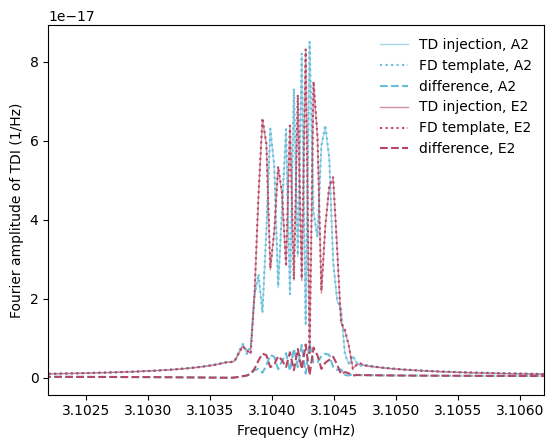

In [8]:
for ich, nch, colch in zip([0, 1], ["A2", "E2"], [BLUE, RED]):
    plt.plot(test_frequency * 1e3, np.abs(test_fd_waveform_from_td[ich]), label="TD injection, "+nch, color=colch, linewidth=1, alpha=0.6)
    plt.plot(test_frequency * 1e3, np.abs(test_fd_waveform[ich]), linestyle=":", label="FD template, "+nch, color=colch)
    plt.plot(test_frequency * 1e3, np.abs(test_fd_waveform_from_td[ich] - test_fd_waveform[ich]), label="difference, "+nch, color=colch, linestyle="--")
plt.legend(loc="upper right", frameon=False)
plt.xlabel("Frequency (mHz)")
plt.ylabel("Fourier amplitude of TDI (1/Hz)")
plt.xlim((test_params["f0"] - 2e-6)*1e3, (test_params["f0"] + 2e-6)*1e3)
# plt.savefig("../Figures/TD_vs_FD.jpg", dpi=300)